<a href="https://colab.research.google.com/github/higordevellard/hotel_sentiment_analysis/blob/main/NLP_Hotel_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - NLP - Review de Hotels (EM DESENVOLVIMENTO)
# Sprint 02 - MVP parte 02






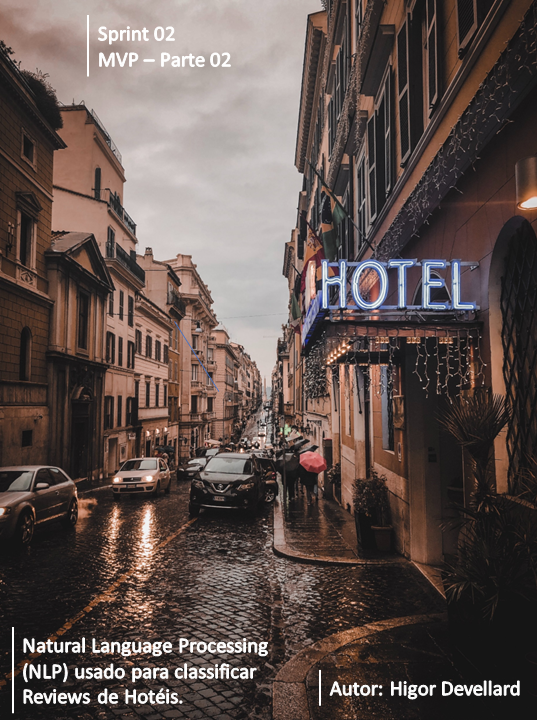

In [1]:
import requests
from PIL import Image
from io import BytesIO

# Carregar a capa do projeto usando a biblioteca PIL
imagem_1 = 'https://raw.githubusercontent.com/higordevellard/hotel_sentiment_analysis/main/images/imagem_1.png'
request_imagem = requests.get(imagem_1)
imagem = Image.open(BytesIO(request_imagem.content))
imagem.show()


## 1.Motivação

*   A satisfação do cliente desempenha um papel fundamental na indústria hoteleira, pois representa a base para o sucesso e a prosperidade de qualquer hotel. Quando os hóspedes estão satisfeitos, eles não apenas retornam ao estabelecimento, mas também o recomendam a amigos e familiares, resultando em um aumento no número de reservas e na reputação positiva do hotel. Além disso, a satisfação do cliente é um indicador crucial da qualidade dos serviços oferecidos, refletindo a capacidade do hotel em atender às expectativas e necessidades dos hóspedes. Ao priorizar a satisfação do cliente, os hotéis podem garantir uma experiência memorável e personalizada, desde o momento da reserva até o check-out.
*   Este projeto tem como objetivo utilizar técnicas de NLP para analisar um dataset contendo reviews elaborados por clientes e assim categorizar os sentimentos presentes nos comentários e assim avaliar se é uma nota negativa, positiva ou neutra.


## 2.Pacotes Usados

In [80]:
# Configuração para não exibir os warnings dos pacotes selecionados
import warnings
warnings.filterwarnings("ignore")

# Importação de pacotes
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

#BERT
import os
import random
from pathlib import Path
import json

import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Configuração para não exibir os warnings dos pacotes selecionados
import warnings
warnings.filterwarnings("ignore")

# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0:00:00


### **2.1.Funções Auxiliares**

In [5]:
import re
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

clean = CleanText()

## 3.Carga do Dataset

O dataset escolhido para este projeto está disponível no Kaggle, conforme o seguinte endereço: https://www.kaggle.com/code/sahillyraina/electric-faults-detection-classification/input


In [6]:
# Localicazão do dataset
url_1 = 'https://raw.githubusercontent.com/higordevellard/hotel_sentiment_analysis/main/review_hotel.csv'

# Labels dos atributos do dataset
labels_atributos = ['Review_Date', 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality', \
                    'Negative_Review', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Positive_Review', \
                    'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags', \
                    'days_since_review']
# Lê o arquivo
dataset = pd.read_csv(url_1, names=labels_atributos, header=0, delimiter=',')


### **3.1.Informações sobre o dataset**

*   O dataset pode ser encontrado no Kaggle, no endereço abaixo, onde foi coletados reviews referente à diversos hoteis em regiões dos da Europa:

https://www.kaggle.com/code/jonathanoheix/sentiment-analysis-with-hotel-reviews/notebook

O dataset carregado contém 13 atributos, sendo eles:

**Review_Date:** data em que foi feito o review.

**Average_Score:**nota média do hotel.

**Hotel_Name:**nome do hotel.

**Reviewer_Nationality:**nacionalidade do usuário que elaborou o review.

**Negative_Review:**pontos negativos sobre o hotel.

**Review_Total_Negative_Word_Counts:**quantidade total de palavras negativas.

**Total_Number_of_Reviews:**quantidade total de reviews do hotel.

**Positive_Review:**Pontos positivos da review.

**Review_Total_Positive_Word_Counts:**quantidade total de palavras positivas.

**Total_Number_of_Reviews_Reviewer_Has_Given:**quantidade de reviews que o usuário fez.

**Reviewer_Score:**nota do review.

**Tags:**tags usadas.

**days_since_review:**quantidade de dias que a review foi feita.



## 4.Análise Exploratória de Dados

###4.1 Análise e Tratamento dos dados

In [7]:
# Mostra as dimensões do dataset (linhas e colunas)
dataset.shape

(65000, 13)

In [8]:
# Mostra as informações do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65000 entries, 0 to 64999
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Review_Date                                 65000 non-null  object 
 1   Average_Score                               65000 non-null  float64
 2   Hotel_Name                                  65000 non-null  object 
 3   Reviewer_Nationality                        65000 non-null  object 
 4   Negative_Review                             65000 non-null  object 
 5   Review_Total_Negative_Word_Counts           65000 non-null  int64  
 6   Total_Number_of_Reviews                     65000 non-null  int64  
 7   Positive_Review                             65000 non-null  object 
 8   Review_Total_Positive_Word_Counts           65000 non-null  int64  
 9   Total_Number_of_Reviews_Reviewer_Has_Given  65000 non-null  int64  
 10  Reviewer_S

**Observações importantes levantadas após os resultados da função .info():**

1)Todos os 13 atributos foram devidamente carregados.

2)Todas as 65.000 Instâncias (linhas) são não nulas (Sem missings).



In [81]:
dataset.head()

,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,review,review_classification
0,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,I am so angry that i made this post available...,0
1,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,No Negative No real complaints the hotel was g...,2
2,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,Rooms are nice but for elderly a bit difficul...,2
3,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,My room was dirty and I was afraid to walk ba...,0
4,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,You When I booked with your company on line y...,1


Como no dataset as avaliações positivas estão armazenadas em um atributo e as negativas em outro, será necessário realizar a concatenação dos dois atributos.

In [10]:
#Concatenação.
dataset["review"] = dataset["Negative_Review"] + dataset["Positive_Review"]

In [11]:
dataset.head()

,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,review
0,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,I am so angry that i made this post available...
1,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,No Negative No real complaints the hotel was g...
2,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,Rooms are nice but for elderly a bit difficul...
3,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,My room was dirty and I was afraid to walk ba...
4,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,You When I booked with your company on line y...


Considerando que no atributo **"Reviewer_Score"** é dada uma nota ao hotel, será dado uma classificação para cada faixa de nota.

In [12]:
def assign_value(x):
    if x < 6:
        return 0
    elif x >= 6 and x < 7:
        return 1
    else:
        return 2

dataset["review_classification"] = dataset["Reviewer_Score"].apply(assign_value)

In [13]:
# label to name
def label2name(x):
    if x == 0:
        return "Negativo"
    if x == 1:
        return "Neutro"
    if x == 2:
        return "Positivo"

In [14]:
#Retornar apenas os atributos que serão usados
dataset_1 = dataset[["review", "Reviewer_Score", "review_classification"]]

#Descrição da classificação do hotel
dataset_1["label_name"] = dataset_1["review_classification"].apply(lambda x: label2name(x))

No dataset escolhido quando o usuário opta por não preencher o atributo "Negative_Review" ou "Positive_Review", automaticamente o dataset é preenchido com "No Negative" ou "No positive", o que não irá ajudar no treinamento do modelo, podendo até atrapalhar no desempenho do mesmo.

In [15]:
# remove 'No Negative' or 'No Positive' from text
dataset_1["review"] = dataset_1["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [16]:
# Limpeza do texto, letras maiúsculas e pontuação.
dataset_1["review"] = dataset_1["review"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))

In [83]:
#Dataset que será usado após tratamento.
dataset_1.head()

,review,Reviewer_Score,review_classification,label_name
0,i am so angry that i made this post available...,2.9,0,Negativo
1,no real complaints the hotel was great great ...,7.5,2,Positivo
2,rooms are nice but for elderly a bit difficul...,7.1,2,Positivo
3,my room was dirty and i was afraid to walk ba...,3.8,0,Negativo
4,you when i booked with your company on line y...,6.7,1,Neutro


### **4.2.Estatísticas Descritivas**

**Balanceamento dos Dados**

In [95]:
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])

colors = ['gold', 'mediumturquoise', 'lightgreen']

fig.add_trace(go.Pie(labels=dataset_1.label_name.value_counts().index,
                     values=dataset_1.review_classification.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=dataset_1.label_name.value_counts().index,
                     y=dataset_1.review_classification.value_counts().values, marker_color=colors), 1, 2)

# Adicionar título em negrito
fig.update_layout(title="Classes do Target - Porcentagem e Quantidade",
                  title_font=dict(size=24, family="Arial", color="black"))

fig.show()

*   Pelo gráfico acima, pode-se perceber um grande desbalanceamento das classes, sendo 84% pertencende a classe "Positivo". Ao treinar o modelo considerando essa distribuição e observando as métricas de precisão, recall e F1-Score, foi notado que o modelo estava com facilidade para reconhecer a classe "Positivo", porém não conseguia reconhecer as outras classes.
*   Dessa maneira, foi optado por balancear as classes, considerando que há 65000 instâncias no dataset, e a classe que possui a menor quantidade de instâncias (6,32%) teria um total de 4109 reviews para essa classe.
*   Sendo assim, foi utilizado o **Random Undersampling** para balancear as classes e salvar na variável "dataset_2".




In [19]:
from imblearn.under_sampling import RandomUnderSampler

# Separar as features (X) do atributo alvo (y)
X = dataset_1.drop('review_classification', axis=1)
y = dataset_1['review_classification']

# Criar uma instância do RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Aplicar o Random Undersampling
X_undersampled, y_undersampled = rus.fit_resample(X, y)

# Criar um novo dataframe com os dados balanceados
dataset_2 = pd.DataFrame(X_undersampled, columns=X.columns)
dataset_2['review_classification'] = y_undersampled

# Verificar o balanceamento das classes no dataset undersampled
dataset_2['review_classification'].value_counts()

0    4109
1    4109
2    4109
Name: review_classification, dtype: int64

In [96]:
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])

colors = ['gold', 'mediumturquoise', 'lightgreen']

fig.add_trace(go.Pie(labels=dataset_2.label_name.value_counts().index,
                     values=dataset_2.review_classification.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=dataset_2.label_name.value_counts().index,
                     y=dataset_2.review_classification.value_counts().values, marker_color=colors), 1, 2)

# Adicionar título em negrito
fig.update_layout(title="Classes do Target - Porcentagem e Quantidade",
                  title_font=dict(size=24, family="Arial", color="black"))

fig.show()

# **5.Visualizações**

## **5.1 Wordcloud**

Com o wordcloud é possível visualizar uma núvem de palavras com base nos dados presentes no atributo "review" do dataset utilizado.

In [98]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

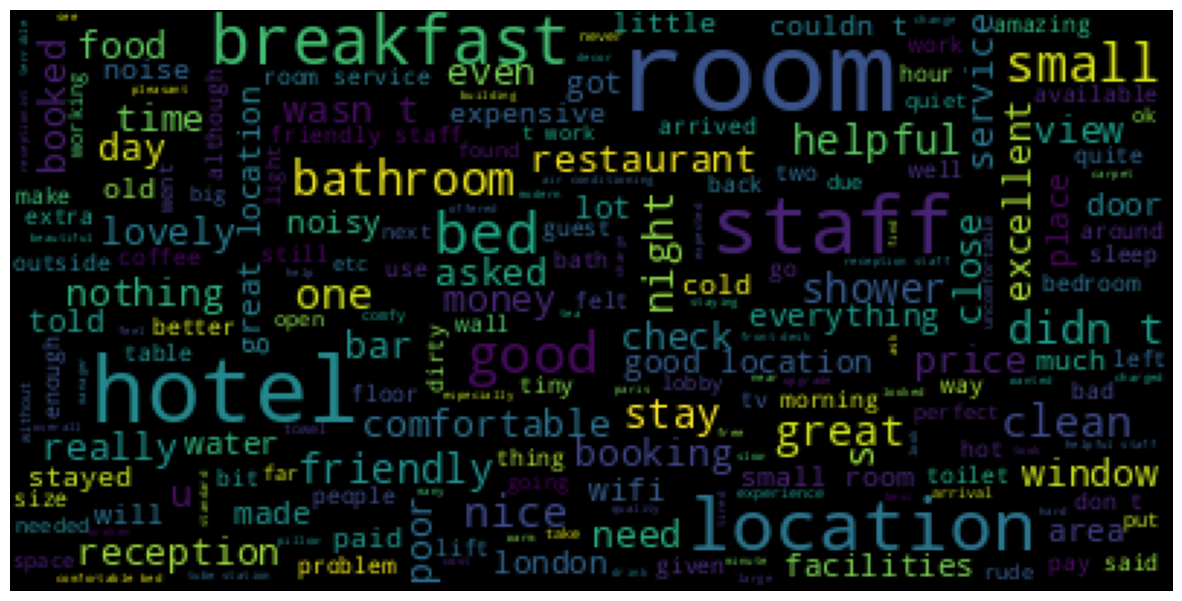

In [23]:
show_wordcloud(dataset_2["review"].values)

Pode-se destacar como as palavras mais usadas como sendo elas: hotel, location, room, staff e breakfast.

## **5.2.Tokeinização**

A tokenização é um processo que divide o texto em unidades significativas, conhecidas como "tokens". Cada token pode ser uma palavra, um caractere ou uma sequência de caracteres, dependendo da forma como a função é implementada.
O algoritmo de classificação que será usado para um texto longo não será o mesmo usado para um texto curto.

### **5.2.1.Tokeinização Simples**

In [24]:
# tokenize data
dataset_2["tokenized_review"] = dataset_2.review.apply(lambda x: tokenize(x))
# calculate token count for any sent
dataset_2["token_comprimento"] = dataset_2["tokenized_review"].apply(lambda x: len(x.split()))

In [99]:
fig = px.histogram(dataset_2, x="token_comprimento", nbins=20, color_discrete_sequence=["blue"], barmode='group', histnorm="percent")
fig.show()

In [101]:
(dataset_2.token_comprimento < 512).mean()

1.0

### **5.2.2.Tokeinização para o BERT**

Como será criado um modelo baseado em Transformers, o valor que o BERT tokinezer nos dará é muito importante. Com as informações obtidas, será decidido o valor do parâmetro **"seq_len"** que será usado durante a codificação dos dados.

In [27]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [28]:
# data tokenize with bert tokenizer
dataset_2["BERT_token_comprimento"] = dataset_2["review"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

In [100]:
fig = px.histogram(dataset_2, x="token_comprimento", nbins=20, color_discrete_sequence=["blue"], barmode='group', histnorm="percent")
fig.show()

In [30]:
# Less than 512 covers how many of the data
(dataset_2.BERT_token_comprimento < 512).mean()

1.0

O comprimento da sequência de índices de token é menor que o comprimento máximo de sequência especificado para este modelo **(menor que 512)** na grande maioria dos reviews. A execução dessa sequência pelo modelo não resultará em erros de indexação.

## **5.3.Contagem de Caracteres**

In [103]:
# Contagem de caracteres para cada review
dataset_2['char_count'] = dataset_2['review'].apply(lambda x: len(str(x)))


def plot_dist3(dataset_2, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(dataset_2.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)

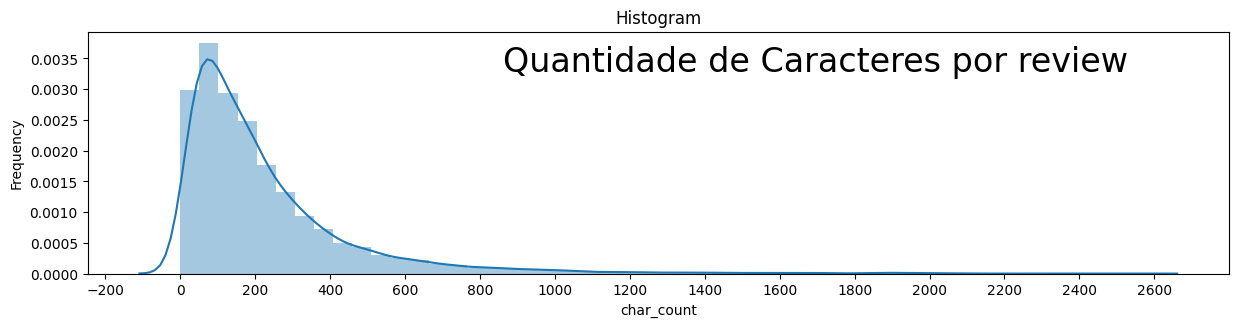

In [113]:
# Contagem de caracteres para cada review
dataset_2['char_count'] = dataset_2['review'].apply(lambda x: len(str(x)))


def plot_dist3(dataset_2, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(dataset_2.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    plt.suptitle(f'{title}', fontsize=24, x=0.45, y=0.95)  # Título centralizado

plot_dist3(dataset_2, 'char_count', 'Quantidade de Caracteres por review')

Pelo gráfico acima, pode-se perceber que a maior frequência de caracteres por review está em torno de 50 à 100 caracteres.

### **5.3.1.Contagem de Caracteres por classe**

In [127]:
#Criação de um novo atributo para visualização.
dataset_2['Character Count'] = dataset_2['review'].apply(lambda x: len(str(x)))


def plot_dist3(dataset_2, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(dataset_2.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#26a7e7')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Função de Distribuição Acumulada')
    # Plotting the ecdf_Plot.
    sns.distplot(dataset_2.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#44199c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

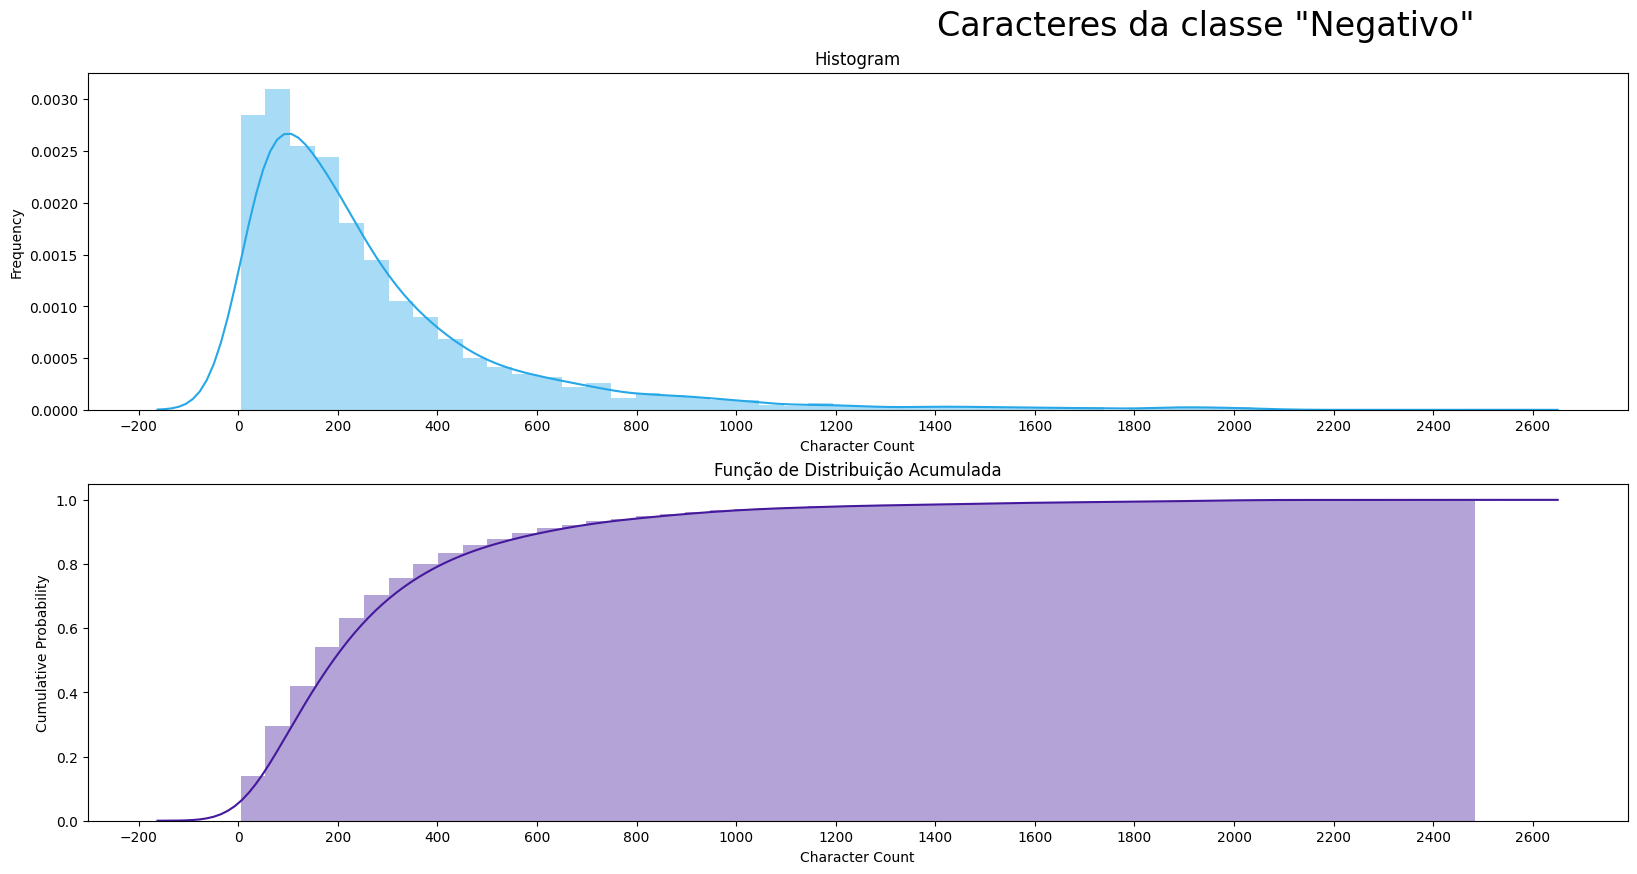

In [128]:
plot_dist3(dataset_2[dataset_2['review_classification'] == 0], 'Character Count',
           'Caracteres da classe "Negativo"')

Avaliando agora a quantidade de caracteres da classe negativo foi plotado um histograma e um gráfico de distribuição acumulada.

*   No histograma pode-se inferir que a maior frequência de caracteres está entre 50 e 100 caracteres
*   Já o gráfico de distribuição acumulada indica, por exemplo, que 400 caracteres podem ser encontrados com a probabilidade acumulada de 80%.



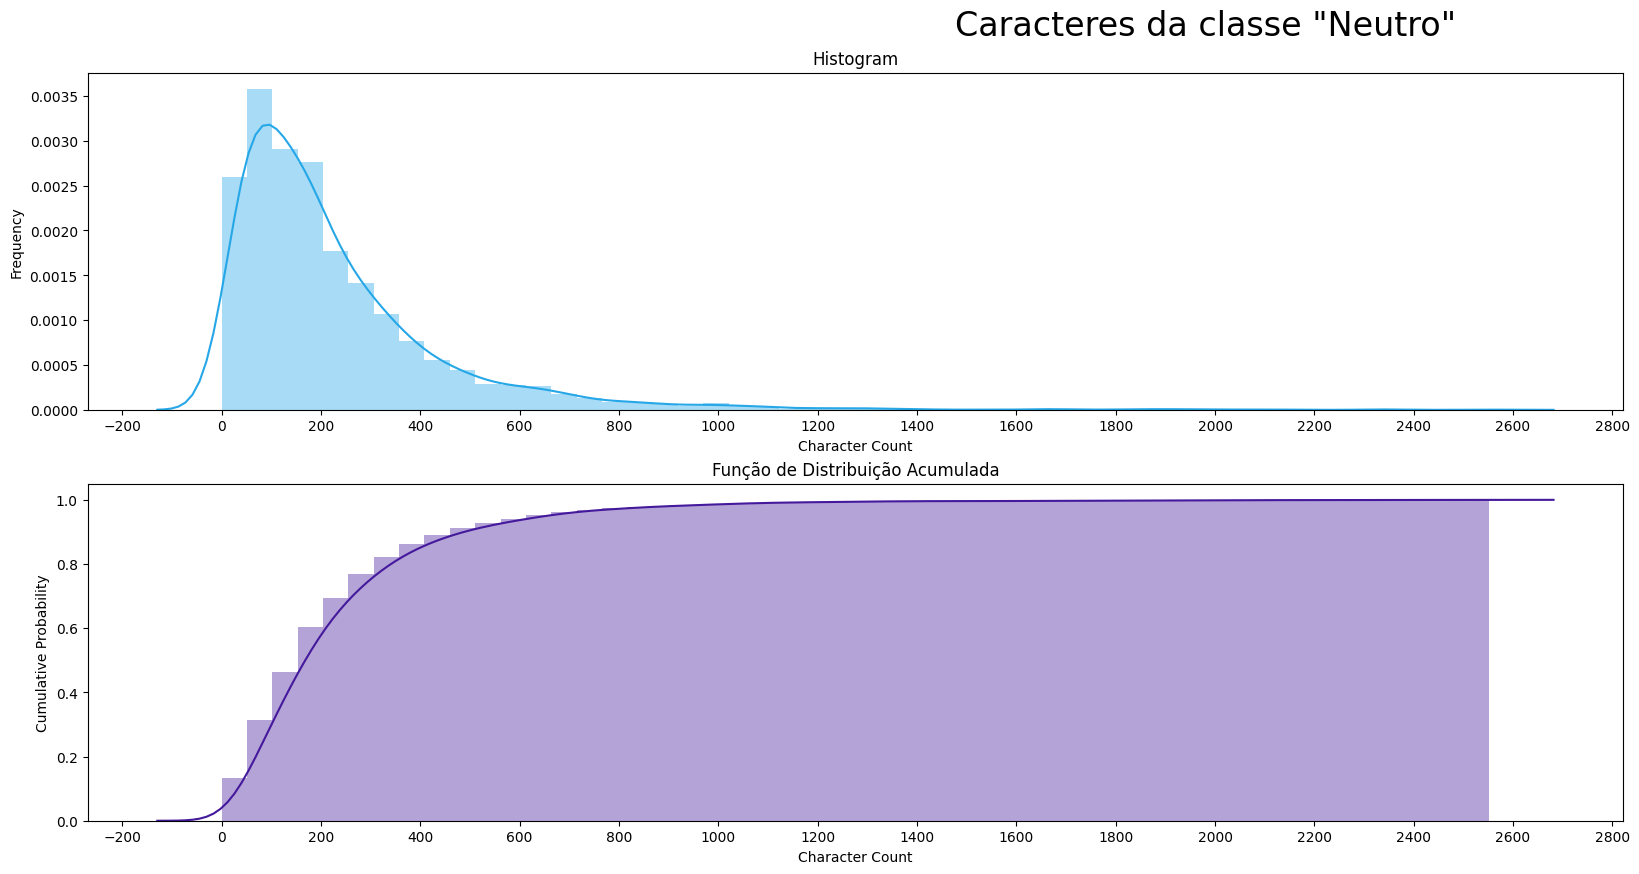

In [130]:
plot_dist3(dataset_2[dataset_2['review_classification'] == 1], 'Character Count',
           'Caracteres da classe "Neutro"')

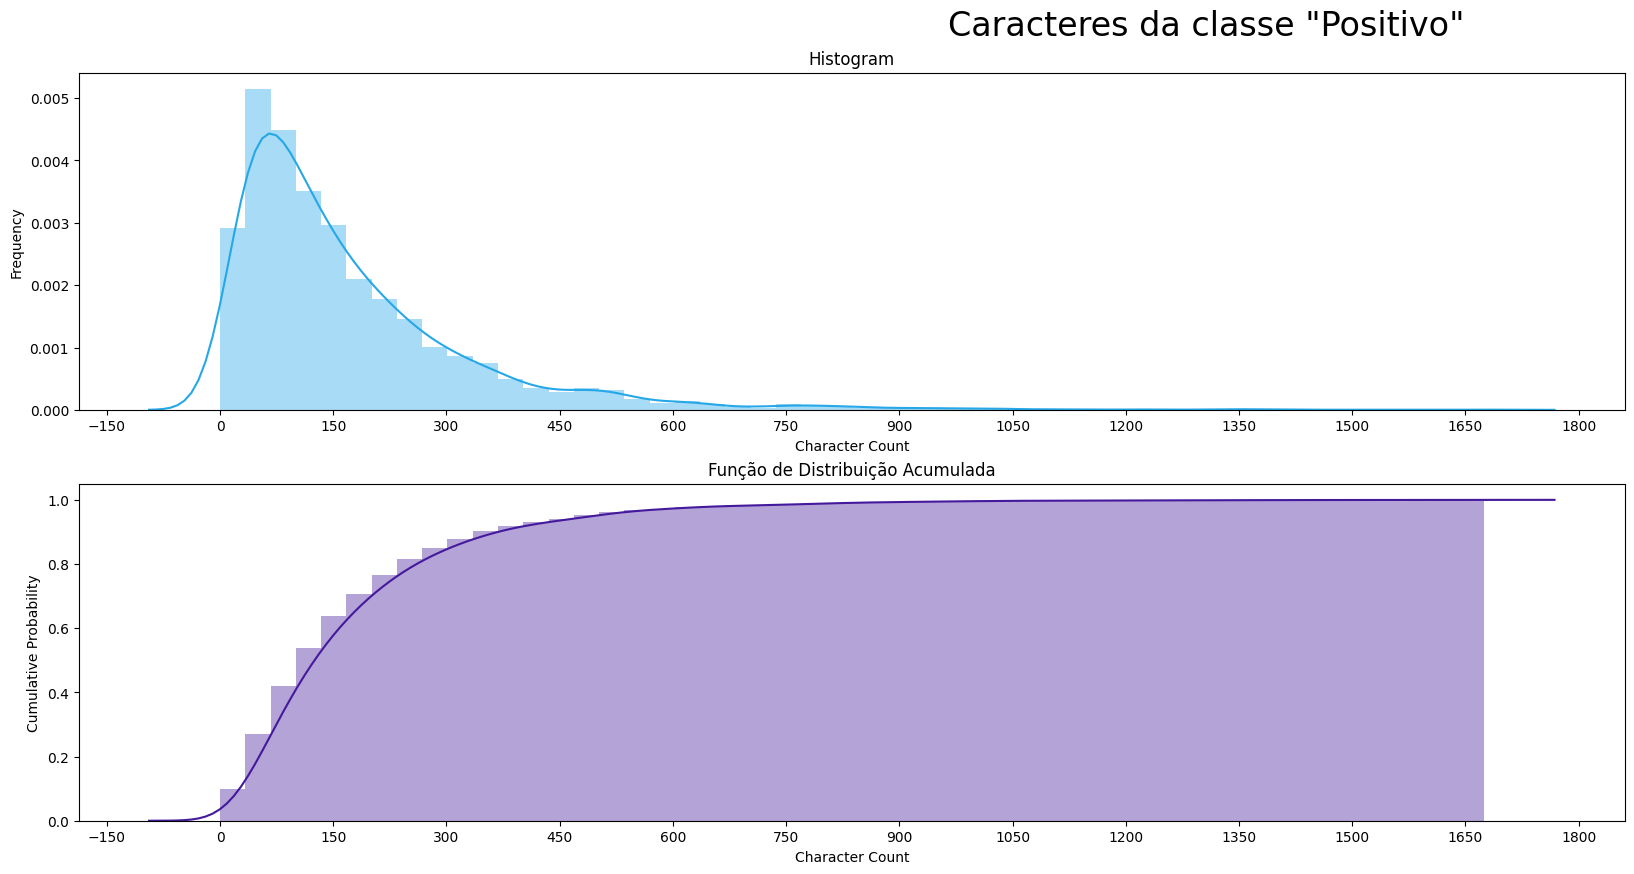

In [131]:
plot_dist3(dataset_2[dataset_2['review_classification'] == 2], 'Character Count',
           'Caracteres da classe "Positivo"')

## **5.4.Contagem de palavras**

Nesse momento a análise está sendo feita considerando a quantidade de palavras por review.

In [132]:
def plot_word_number_histogram(texta, textyb, textc):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    sns.distplot(texta.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textyb.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textc.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')


    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Negativo')
    axes[1].set_xlabel('Word Count')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Neutro')
    axes[2].set_xlabel('Word Count')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Positivo')

    fig.suptitle('Palavras por Review', fontsize=24, va='baseline')

    fig.tight_layout()

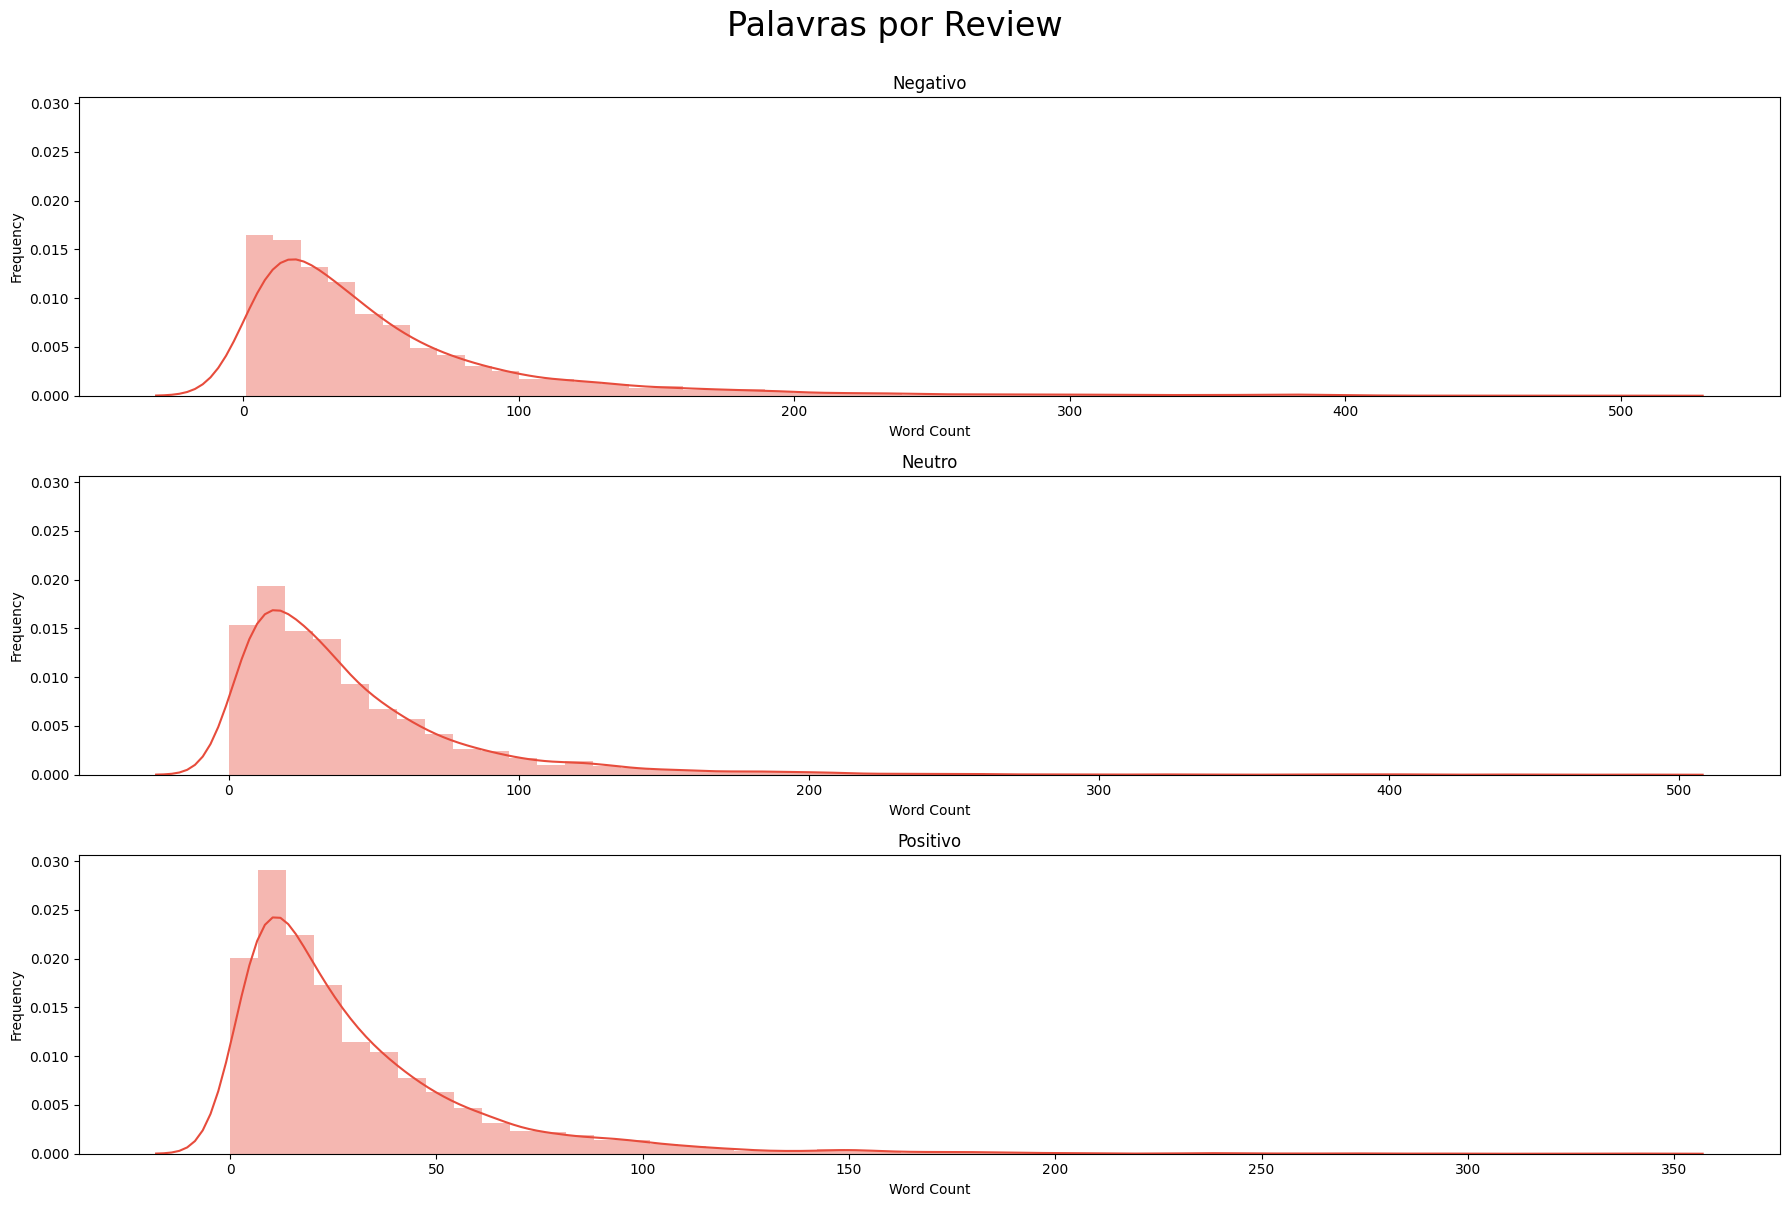

In [133]:
plot_word_number_histogram(dataset_2[dataset_2['review_classification'] == 0]['review'],
                           dataset_2[dataset_2['review_classification'] == 1]['review'],
                           dataset_2[dataset_2['review_classification'] == 2]['review'],
                          )

Com a visualização dos histogramas para a quantidade de palavras para cada classe, é possível observar, por exemplo, que para a classe "positivo", a maior frequência é de aproximadamente 10 à 20 palavras.

In [39]:
# remove pontuação
dataset_2['tokenized_review'] = dataset_2['tokenized_review'].apply(lambda x: remove_punct(x))

## **5.5.Contagem de Caracteres**

In [135]:
texts = dataset_2['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Palavras mais comuns",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

Pode-se inferir que a palavra mais mencionada é a palavra "room" sendo mencionada 10.788 vezes.

### **5.5.1.Contagem de Palavras - por classe**



In [136]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negativo", "neutro", "positivo"]

for i in range(3):
    texts = dataset_2[dataset_2["review_classification"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Palavras mais comuns por classe</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

### **5.5.2.Contagem de duas Palavras Seguidas - por classe**




In [42]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [137]:
# unigram
fig = make_subplots(rows=1, cols=3)

title_ = ["negativo", "neutro", "positivo"]

for i in range(3):
    texts = dataset_2[dataset_2["review_classification"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)


fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Palavras seguidas mais comuns - por classe</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
fig.show()

### **5.5.3.Contagem de três Palavras seguidas - por classe**

In [44]:
#trigram

fig = make_subplots(rows=1, cols=3)
title_ = ["negativo", "neutro", "positivo"]

for i in range(3):
    texts = dataset_2[dataset_2["review_classification"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Contagem de três palavras seguidas por classe</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))

fig.show()

Agora que já foi feita toda a visualização dos dados, partiremos para a criação do modelo.

## **6.Criação do Modelo**

### **6.1.BERT**

O BERT faz uso do Transformer, um mecanismo que aprende relações contextuais entre palavras (ou subpalavras) em um texto. Em sua forma padrão, o Transformer inclui dois mecanismos separados — um codificador que lê a entrada de texto e um decodificador que produz uma previsão para a tarefa. Como o objetivo do BERT é gerar um modelo de linguagem, apenas o mecanismo do codificador é necessário.

O BERT é um transformador bidirecional para pré-treinamento em muitos dados textuais não rotulados para aprender uma representação de linguagem que pode ser usada para ajustar tarefas específicas de aprendizado de máquina. Embora o BERT tenha superado o estado da arte do NLP em várias tarefas desafiadoras, sua melhoria de desempenho pode ser atribuída ao transformador bidirecional, às novas tarefas de pré-treinamento do modelo de linguagem mascarada e à previsão da próxima estrutura, juntamente com muitos dados e computação do Google.

A seguir será feita a configuração do modelo e definição de parâmetros.

In [47]:
# Configuração do modelo.
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True
    return_attention_mask=True
    pad_to_max_length=True
    do_lower_case=False
    return_tensors='pt'

config = Config()

Inicialmente será considerado o número de "epochs" igual a 5.

In [48]:
# Definição de parâmetros
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [49]:
# Definição de semente aleatória.

device = config.device
random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [50]:
dataset_2.head()

,review,Reviewer_Score,label_name,review_classification,tokenized_review,token_comprimento,BERT_token_comprimento,char_count,Character Count
0,staying on a building site the hotel was unde...,5.4,Negativo,0,staying on a building site the hotel was under...,40,40,202,202
1,the hotel was very dilapidated the decour was...,4.2,Negativo,0,the hotel was very dilapidated the decour was ...,164,175,859,859
2,check in staff not helpful lobby small and th...,3.8,Negativo,0,check in staff not helpful lobby small and the...,65,65,391,391
3,the shower door was missing and the blind on ...,5.8,Negativo,0,the shower door was missing and the blind on t...,27,27,153,153
4,the fact that the room was much smaller than ...,5.8,Negativo,0,the fact that the room was much smaller than t...,15,15,93,93


### **6.2.Separação dos dados em Treino, Validação e Treino**

**Treino e Validação**

In [141]:
#split train test
from sklearn.model_selection import train_test_split

train_df_, val_df = train_test_split(dataset_2,
                                    test_size=0.10,
                                    random_state=config.random_state,
                            stratify=dataset_2.review_classification.values)

**Treino e Teste**

In [142]:
train_df, test_df = train_test_split(train_df_,
                                    test_size=0.10,
                                    random_state=42,
                            stratify=train_df_.review_classification.values)

Para esse projeto está sendo considerado 10% dos dados para teste e 90% para treino, sendo 10% dos dados para treinos usado na validação.

**Número instâncias para treino**

In [143]:
# count of unique label  control
print(len(train_df['review_classification'].unique()))
print(train_df.shape)

3
(9984, 9)


03 = quantidade de rótulos.

9984 = quantidade de instâncias.

09 = quantidade de atributos.

**Número instâncias para validação**

In [144]:
# count of unique label  control
print(len(val_df['review_classification'].unique()))
print(val_df.shape)

3
(1233, 9)


**Número instâncias para teste**

In [145]:
print(len(test_df['review_classification'].unique()))
print(test_df.shape)

3
(1110, 9)


### **6.3.Tokeinização e Encoding**

In [56]:
# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model,
                                          do_lower_case=config.do_lower_case)

In [57]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.review.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.review.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [58]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.review_classification.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.review_classification.values)

In [59]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

### **6.4.Criação do Modelo**

In [60]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

**Carregamento**

In [61]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=config.batch_size)

**Optimização e Scheduler**

In [62]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr,
                  eps=config.eps)


scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

**Métricas de Performance**

In [63]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## **7.Treinamento**

In [64]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(config.device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [65]:
config.device

device(type='cuda', index=0)

In [66]:
model.to(config.device)

for epoch in tqdm(range(1, config.epochs+1)):

    model.train()

    loss_train_total = 0
    # allows you to see the progress of the training
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(config.device) for b in batch)


        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')

    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1007 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.836971036520118
Validation loss: 0.7540465974923664
F1 Score (Weighted): 0.6462738219480487


Epoch 2:   0%|          | 0/1007 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6443688380564336
Validation loss: 0.8098959768948717
F1 Score (Weighted): 0.6533765005966637


Epoch 3:   0%|          | 0/1007 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.45821642165757576
Validation loss: 1.1762499245097997
F1 Score (Weighted): 0.6399360043758835


Epoch 4:   0%|          | 0/1007 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.3148695940101869
Validation loss: 1.7063156405808722
F1 Score (Weighted): 0.6318195045871693


Epoch 5:   0%|          | 0/1007 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.21218607806086878
Validation loss: 1.9339775446275207
F1 Score (Weighted): 0.64077824621265


O código apresenta informações sobre o treinamento de um modelo ao longo de várias épocas. Cada época é representada por um número e é seguida por algumas métricas de desempenho. Vamos interpretar o código linha por linha:


Epoch 1: Esta linha indica que é a primeira época.


Training loss: 0.836971036520118: Isso indica o valor da perda (loss) durante o treinamento na primeira época. Quanto menor o valor da perda, melhor o desempenho do modelo.


Validation loss: 0.7540465974923664: Isso indica o valor da perda durante a validação na primeira época. A validação é uma etapa em que o modelo é avaliado em um conjunto de dados separado para verificar seu desempenho em dados não vistos anteriormente.


F1 Score (Weighted): 0.6462738219480487: Esse valor representa o F1-Score ponderado na primeira época. O F1-Score é uma métrica comum de avaliação de modelos de classificação, que combina a precisão e a revocação. O F1-Score ponderado leva em consideração a distribuição das classes.


Essas mesmas informações são fornecidas para cada época subsequente (Epoch 2, Epoch 3, etc.), mas com valores diferentes de perda e métricas de desempenho correspondentes a cada época específica. As métricas de desempenho fornecidas no código são perda (loss) e F1-Score ponderado, mas podem variar dependendo do contexto do código e do problema em questão.


Essas informações são úteis para acompanhar o progresso do treinamento do modelo ao longo das épocas e para avaliar a qualidade do modelo com base nas métricas de desempenho fornecidas.

## **7.1.Treinamento no set de validação**

In [67]:
model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [68]:
from sklearn.metrics import classification_report

preds_flat = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds_flat, true_vals))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62      1121
           1       0.58      0.50      0.54      1414
           2       0.74      0.78      0.76      1164

    accuracy                           0.64      3699
   macro avg       0.64      0.65      0.64      3699
weighted avg       0.63      0.64      0.63      3699



Os resultados fornecidos representam as métricas de avaliação de um modelo de classificação em um conjunto de dados. Vamos interpretar cada uma das métricas:

Precision (Precisão): A precisão é a proporção de exemplos classificados corretamente como positivos (verdadeiros positivos) em relação ao total de exemplos classificados como positivos (verdadeiros positivos + falsos positivos). Para a classe 0, a precisão é de 0.59, para a classe 1 é de 0.58 e para a classe 2 é de 0.74.

Recall (Revocação): A revocação é a proporção de exemplos classificados corretamente como positivos (verdadeiros positivos) em relação ao total de exemplos que realmente são positivos (verdadeiros positivos + falsos negativos). Para a classe 0, o recall é de 0.65, para a classe 1 é de 0.50 e para a classe 2 é de 0.78.

F1-Score: O F1-Score é uma métrica que combina a precisão e a revocação em uma única medida. Ele é calculado como a média harmônica entre a precisão e a revocação. Para a classe 0, o F1-Score é de 0.62, para a classe 1 é de 0.54 e para a classe 2 é de 0.76.

Support (Suporte): O suporte é o número de exemplos verdadeiros de cada classe presente no conjunto de dados. Para a classe 0, o suporte é de 1121 exemplos, para a classe 1 é de 1414 exemplos e para a classe 2 é de 1164 exemplos.

Accuracy (Acurácia): A acurácia é a proporção de exemplos classificados corretamente em relação ao total de exemplos. Nesse caso, a acurácia é de 0.64, o que significa que o modelo classificou corretamente 64% dos exemplos.

Macro avg (Média Macro): A média macro é a média das métricas (precisão, revocação, F1-Score) calculadas individualmente para cada classe, atribuindo o mesmo peso a cada classe. No caso desses resultados, a média macro para precisão, revocação e F1-Score é de 0.64.

Weighted avg (Média Ponderada): A média ponderada é a média das métricas calculadas individualmente para cada classe, atribuindo pesos diferentes com base no suporte de cada classe. No caso desses resultados, a média ponderada para precisão, revocação e F1-Score é de 0.63.

Essas métricas fornecem uma visão geral do desempenho do modelo de classificação para cada classe individualmente e para o conjunto de dados como um todo. A precisão, revocação e F1-Score são úteis para avaliar a qualidade do modelo, enquanto o suporte indica a quantidade de exemplos de cada classe no conjunto de dados. A acurácia fornece uma medida geral de quão bem o modelo está classificando corretamente os exemplos em relação ao total.

## **7.1.Análise do Erro**

In [69]:
# previsões passo a passo no dataframe
# Fazemos isso para visualizar as previsões no dataframe do pandas e filtrá-las facilmente e realizar análises de erros.

pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    review = row["review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review],
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']


    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/3699 [00:00<?, ?it/s]

In [70]:
# adiciona o atributo 'pred' into val_df
val_df["pred"] = pred_final

In [71]:
val_df.head()

,review,Reviewer_Score,label_name,review_classification,tokenized_review,token_comprimento,BERT_token_comprimento,char_count,Character Count,pred
6116,ignorant staff location was excellent,6.3,Neutro,1,ignorant staff location was excellent,5,5,38,38,1
8442,some of the foreign staff couldn t understand...,9.6,Positivo,2,some of the foreign staff couldn t understand ...,34,34,187,187,2
7288,very small room not good value for money i li...,6.3,Neutro,1,very small room not good value for money i lik...,34,34,179,179,1
8978,amazing hotel the staff were very friendly an...,10.0,Positivo,2,amazing hotel the staff were very friendly and...,29,30,148,148,2
9597,stlyle location welcome staff security,8.3,Positivo,2,stlyle location welcome staff security,5,7,39,39,2


In [72]:
# Adicionar coluna de controle para previsões erradas e certas mais fáceis
control = val_df.pred.values == val_df.review_classification.values
val_df["control"] = control

In [73]:
# filtragem de previsões falsas
val_df = val_df[val_df.control == False]

In [74]:
# rótulo para mapeamento de intenção
name2label = {"Negativo":0,
              "Neutro":1,
             "Positivo":2
             }
label2name = {v: k for k, v in name2label.items()}

val_df["pred_name"] = val_df.pred.apply(lambda x: label2name.get(x))

In [75]:
from sklearn.metrics import confusion_matrix

# Criamos uma matriz de confusão para observar melhor as classes que o modelo confunde.
pred_name_values = val_df.pred_name.values
label_values = val_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [76]:
confmat

array([[  0, 422,  57],
       [363,   0, 141],
       [ 52, 318,   0]])

In [140]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

col_0,Negativo,Neutro,Positivo
row_0,,,
Negativo,0,422,57
Neutro,363,0,141
Positivo,52,318,0


A matriz de confusão apresentada é uma representação tabular dos resultados da classificação para um modelo. Cada célula da matriz mostra a contagem de instâncias classificadas em uma determinada classe (linha) em relação à classe real (coluna). Vamos interpretar essa matriz de confusão:

Coluna "col_0": As classes preditas pelo modelo são representadas como "Negativo", "Neutro" e "Positivo".

Linha "row_0": As classes reais são representadas como "Negativo", "Neutro" e "Positivo".

A interpretação da matriz de confusão é feita olhando-se as interseções entre as linhas e colunas. Cada célula da matriz fornece a contagem de instâncias que foram classificadas em determinada classe. Portanto, a interpretação dos valores é a seguinte:

Na célula (row_0 = "Negativo", col_0 = "Negativo"): Não há instâncias classificadas corretamente como "Negativo". O valor é 0.

Na célula (row_0 = "Negativo", col_0 = "Neutro"): Existem 422 instâncias reais da classe "Negativo" que foram classificadas como "Neutro".

Na célula (row_0 = "Negativo", col_0 = "Positivo"): Existem 57 instâncias reais da classe "Negativo" que foram classificadas como "Positivo".

Na célula (row_0 = "Neutro", col_0 = "Negativo"): Existem 363 instâncias reais da classe "Neutro" que foram classificadas como "Negativo".

Na célula (row_0 = "Neutro", col_0 = "Neutro"): Não há instâncias classificadas corretamente como "Neutro". O valor é 0.

Na célula (row_0 = "Neutro", col_0 = "Positivo"): Existem 141 instâncias reais da classe "Neutro" que foram classificadas como "Positivo".

Na célula (row_0 = "Positivo", col_0 = "Negativo"): Existem 52 instâncias reais da classe "Positivo" que foram classificadas como "Negativo".

Na célula (row_0 = "Positivo", col_0 = "Neutro"): Existem 318 instâncias reais da classe "Positivo" que foram classificadas como "Neutro".

Na célula (row_0 = "Positivo", col_0 = "Positivo"): Não há instâncias classificadas corretamente como "Positivo". O valor é 0.

Essa matriz de confusão mostra como o modelo classificou as instâncias para cada classe, permitindo uma análise mais detalhada dos acertos e erros de classificação.

## **7.Simulando a Aplicação do modelo em dados não vistos**


In [79]:
import torch
from transformers import BertTokenizer

# Carregar o tokenizer usado durante o treinamento
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Texto de teste
text = "bad and small"

# Pré-processamento do texto
tokens = tokenizer.encode_plus(
    text,
    max_length=config.seq_length,
    truncation=True,
    padding='max_length',
    return_tensors='pt'
)

# Converter os tokens em tensores do PyTorch
input_ids = tokens['input_ids'].to(config.device)
attention_mask = tokens['attention_mask'].to(config.device)

# Alimentar o texto para o modelo
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

# Obter as predições
logits = outputs[0]
predictions = torch.argmax(logits, dim=1)

# Imprimir as predições
print("Predição:", predictions.item())

Predição: 0


## **6.Conclusão**

Falar sobre o balanceamento das classes

É completamente possível usar apenas texto bruto como entrada para fazer previsões. O mais importante é poder extrair os recursos relevantes dessa fonte bruta de dados. Esse tipo de dado muitas vezes pode vir como uma boa fonte complementar em projetos de ciência de dados, a fim de extrair mais recursos de aprendizado e aumentar o poder preditivo dos modelos.
